In [1]:
# import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# create a query for dates and look for the latest date
latestDate = (session.query(Measurement.date).order_by(Measurement.date.desc()).first())


In [11]:
# extract string form query object
latestDate = list(np.ravel(latestDate))[0]
# convert date string to datetime format
latestDate = dt.datetime.strptime(latestDate, '%Y-%m-%d')


In [12]:
# extract year, momnth, day as integers
latestYear = int(dt.datetime.strftime(latestDate, '%Y'))
latestMonth = int(dt.datetime.strftime(latestDate, '%m'))
latestDay = int(dt.datetime.strftime(latestDate, '%d'))

# calculate the year before the latest date
yearBefore = dt.date(latestYear, latestMonth, latestDay) - dt.timedelta(days=365)
yearBefore

datetime.date(2016, 8, 23)

In [13]:
# query to retrieve the dates and precipitation scores for the latest year
rainData = (session.query(Measurement.date, Measurement.prcp).
            filter(Measurement.date > yearBefore).order_by(Measurement.date).all())

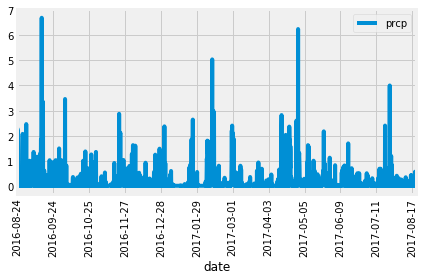

In [14]:
# convert the query results as a Pandas DataFrame and set the index to the date column
rainTable = pd.DataFrame(rainData)
#rainTable.head()
rainTable  = rainTable.set_index('date')

# sort the data by date
rainTable = rainTable.sort_index(ascending=True)

# fill all Nan to 0 
rainTable = rainTable.fillna(0)

# plot the data result with matplotlib
ax = rainTable.plot(use_index=True, y= 'prcp')
xtick = np.arange(0, rainTable.shape[0],200)
ax.set_xticks(xtick)

# rotate the xticks for dates
ax.set_xticklabels([rainTable.index[i] for i in xtick], rotation=90)

plt.tight_layout()
plt.show()

In [15]:
rainTable.index

Index(['2016-08-24', '2016-08-24', '2016-08-24', '2016-08-24', '2016-08-24',
       '2016-08-24', '2016-08-24', '2016-08-25', '2016-08-25', '2016-08-25',
       ...
       '2017-08-21', '2017-08-21', '2017-08-21', '2017-08-22', '2017-08-22',
       '2017-08-22', '2017-08-23', '2017-08-23', '2017-08-23', '2017-08-23'],
      dtype='object', name='date', length=2223)

In [16]:
# calculate the summary statistics for prcp data
rainTable.describe()

,prcp
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
stationCount = session.query(Station).count()
print(f"Station Count: {stationCount}")

Station Count: 9


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stationCounts = (session.query(Measurement.station, func.count(Measurement.station))
                .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all())

stationCounts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# query for the most active station
stationID = stationCounts[0][0]

# query for station name
stationName = (session.query(Station.name).filter_by(station=stationID))

stationName = stationName[0][0]
print(f"The most active station is {stationID}: {stationName}")

# query for the highest temp.
highestTemp = (session.query(Measurement.tobs).filter(Measurement.station == stationID)
              .order_by(Measurement.tobs.desc()).first())
highestTemp = highestTemp[0]
print(f"The highest temperature record there is {highestTemp} degrees Fahrenheit.")

# query for the lowest temp.
lowestTemp = (session.query(Measurement.tobs).filter(Measurement.station == stationID)
              .order_by(Measurement.tobs.desc()).first())
lowestTemp = lowestTemp[0]
print(f"The lowest temperature record there is {lowestTemp} degrees Fahrenheit.")

# query for the average temp.
avgTemp = (session.query(Measurement.tobs).filter(Measurement.station == stationID))
avgTemp = '{0:.3}'.format(avgTemp[0][0])
print(f"The average temperature record there is {avgTemp} degrees Fahrenheit.")

The most active station is USC00519281: WAIHEE 837.5, HI US
The highest temperature record there is 85.0 degrees Fahrenheit.
The lowest temperature record there is 85.0 degrees Fahrenheit.
The average temperature record there is 70.0 degrees Fahrenheit.


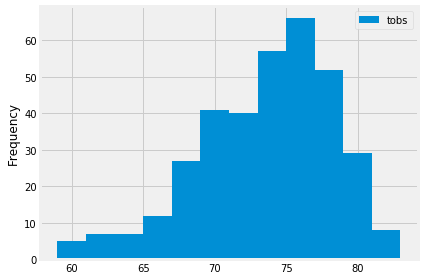

In [20]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempData = (session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > yearBefore)
            .filter(Measurement.station == stationID).order_by(Measurement.date).all())

# convert the query results as a Pandas DataFrame and set the index to the date column
tempTable = pd.DataFrame(tempData)
tempTable = tempTable.set_index('date')

# sort the data by date
tempTable = tempTable.sort_index(ascending=True)

# plot the data result with matplotlib
tempTable.plot.hist(bins=12)
plt.tight_layout()
plt.show()


In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# based off 10 days of vacation time: today = dt.date(2017,8,24)

today = dt.date(2017,8,24)
startDate = today - dt.timedelta(days=365)
endDate = startDate + dt.timedelta(days=10)

tmin, tavg, tmax = calc_temps(startDate, endDate)[0]
print(tmin, tavg, tmax)


71.0 78.37142857142857 84.0


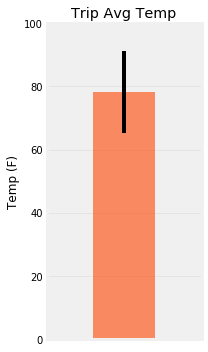

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig = plt.figure(figsize=(3,5))

plt.subplot()
plt.bar(x=0, height=tavg, yerr=(tmax-tmin), color='orangered', alpha= .6)
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.ylim(0, 100)
plt.xlim(-1, 1)
plt.xticks([])
plt.grid(alpha=.3)

plt.tight_layout()
plt.show()


In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = ([Station.station,Station.name, func.sum(Measurement.prcp),
        Station.latitude, Station.longitude, Station.elevation])

stationRain = (session.query(*sel).filter(Station.station == Measurement.station)
              .filter(Measurement.date >= startDate)
              .filter(Measurement.date <= endDate)
              .group_by(Station.station)
              .order_by(func.sum(Measurement.prcp).desc()).all())


# convert the query results as a Pandas DataFrame 
stationRainTable = pd.DataFrame(stationRain, columns=["Station", "Location", "Total Precipitation", "Latitude", "Longitude", "Elevation"])
stationRainTable


,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",8.08,21.33310,-157.80250,152.4
1,USC00519281,"WAIHEE 837.5, HI US",3.68,21.45167,-157.84889,32.9
2,USC00513117,"KANEOHE 838.1, HI US",2.94,21.42340,-157.80150,14.6
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2.69,21.52130,-157.83740,7.0
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",1.90,21.33556,-157.71139,19.5
5,USC00519397,"WAIKIKI 717.2, HI US",0.30,21.27160,-157.81680,3.0
6,USC00517948,"PEARL CITY, HI US",0.06,21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [36]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
startDate = today
vacationDays = 10

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
vacationDates = [(startDate + dt.timedelta(days=i)).strftime("%m-%d") for i in range (vacationDays)]
#vacationDates 

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(date)[0] for date in vacationDates]
normals

[(70.0, 75.96153846153847, 84.0),
 (69.0, 76.96078431372548, 82.0),
 (71.0, 76.56862745098039, 84.0),
 (68.0, 76.28301886792453, 84.0),
 (67.0, 76.73469387755102, 86.0),
 (70.0, 76.23529411764706, 85.0),
 (68.0, 76.41666666666667, 84.0),
 (67.0, 76.84, 85.0),
 (69.0, 77.0, 82.0),
 (67.0, 76.66666666666667, 83.0)]

In [38]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals = pd.DataFrame(normals, columns=["Low Temp", "Avg Temp", "High Temp"])
normals["Date"] = vacationDates
normals = normals.set_index("Date")
normals

,Low Temp,Avg Temp,High Temp
Date,,,
08-24,70.0,75.961538,84.0
08-25,69.0,76.960784,82.0
08-26,71.0,76.568627,84.0
08-27,68.0,76.283019,84.0
08-28,67.0,76.734694,86.0
08-29,70.0,76.235294,85.0
08-30,68.0,76.416667,84.0
08-31,67.0,76.840000,85.0
09-01,69.0,77.000000,82.0


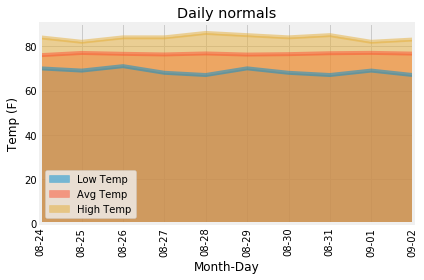

In [40]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normals.plot.area(stacked=False)
ax.set_ylabel('Temp (F)')
ax.set_xlabel('Month-Day')
ax.set_xlim(0,9)
ax.set_xticklabels(vacationDates, rotation=90)
ax.set_title('Daily normals')

plt.tight_layout()
plt.show()
